<p style="border: 1px solid #e7692c; border-left: 15px solid #e7692c; padding: 10px; text-align:justify;">
    <strong style="color: #e7692c">Tip.</strong> <a style="color: #000000;" href="https://nbviewer.jupyter.org/github/PacktPublishing/Hands-On-Computer-Vision-with-TensorFlow-2/blob/master/Chapter06/ch6_nb3_improve_image_quality_with_dae.ipynb" title="View with Jupyter Online">Click here to view this notebook on <code>nbviewer.jupyter.org</code></a>. 
    <br/>These notebooks are better read there, as Github default viewer ignores some of the formatting and interactive content.
    </p>

<table style="font-size: 1em; padding: 0; margin: 0;">
    <tr style="vertical-align: top; padding: 0; margin: 0;background-color: #ffffff">
        <td style="vertical-align: top; padding: 0; margin: 0; padding-right: 15px;">
    <p style="background: #363636; color:#ffffff; text-align:justify; padding: 10px 25px;">
        <strong style="font-size: 1.0em;"><span style="font-size: 1.2em;"><span style="color: #e7692c;">Hands-on</span> Computer Vision with TensorFlow 2</span><br/>by <em>Eliot Andres</em> & <em>Benjamin Planche</em> (Packt Pub.)</strong><br/><br/>
        <strong>> Chapter 6: Enhancing and Segmenting Images </strong><br/>
    </p>

<h1 style="width: 100%; text-align: left; padding: 0px 25px;"><small style="color: #e7692c;">
    Notebook 3:</small><br/>Improving Image Quality with Deep Auto-Encoders (Super-Resolution)</h1>
<br/>
<p style="border-left: 15px solid #363636; text-align:justify; padding: 0 10px;">
    So far in previous notebooks, we applied shallow fully-connected auto-encoders to synthetic problems. It is now time to experiment with some of the more advanced architectures presented in Chapter 6. For that, we also need a more challenging task. 
<br/><br/>
Therefore, we will implement a standard <strong><em>deep auto-encoder (DAE)</strong></em> and use it to improve the resolution of downsampled images. This task, called <strong><em>image super-resolution</strong></em>, can be considered as a variant of _image denoising_. Here, the model should remove the artifacts caused by the downsampling, and try to recover some details lost in the process.
<br/><br/>
In a second time, we will implement our own <strong><em>U-Net</strong></em> model from scratch, and compare its performance with our first solution. 
</p>
<br/>
<p style="border-left: 15px solid #e7692c; padding: 0 10px; text-align:justify;">
    <strong style="color: #e7692c;">Tip.</strong> The notebooks shared on this git repository illustrate some notions from the book "<em><strong>Hands-on Computer Vision with TensorFlow 2</strong></em>" written by Eliot Andres and Benjamin Planche, published by Packt. If you enjoyed the insights shared here, <a href="https://www.amazon.com/Hands-Computer-Vision-TensorFlow-processing/dp/1788830644" title="Learn more about the book!"><strong>please consider acquiring the book!</strong></a>
<br/><br/>
The book provides further guidance for those eager to learn about computer vision and to harness the power of TensorFlow 2 and Keras to build efficient recognition systems for object detection, segmentation, video processing, smartphone applications, and more.</p>
        </td>
        <td style="vertical-align: top; padding: 0; margin: 0; width: 280px;">
    <a href="https://www.amazon.com/Hands-Computer-Vision-TensorFlow-processing/dp/1788830644" title="Learn more about the book!" target="_blank">
        <img src="../banner_images/book_cover.png" width=280>
    </a>
    <p style="background: #e7692c; color:#ffffff; padding: 10px; text-align:justify;"><strong>Leverage deep learning to create powerful image processing apps with TensorFlow 2 and Keras. <br/></strong>Get the book for more insights!</p>
    <ul style="height: 32px; white-space: nowrap; text-align: center; margin: 0px; padding: 0px; padding-top: 10px;">
    <li style="display: block;height: 100%;float: left;vertical-align: middle;margin: 0 25px 10px;padding: 0px;">
        <a href="https://www.amazon.com/Hands-Computer-Vision-TensorFlow-processing/dp/1788830644" title="Get the book on Amazon (paperback or Kindle version)!" target="_blank">
        <img style="vertical-align: middle; max-width: 72px; max-height: 32px;" src="../banner_images/logo_amazon.png" width="75px">
        </a>
    </li>
    <li style="display: inline-block;height: 100%;vertical-align: middle;float: right;margin: -5px 25px 10px;padding: 0px;">
        <a href="https://www.packtpub.com/application-development/hands-computer-vision-tensorflow-2" title="Get your Packt book (paperback, PDF, ePUB, or MOBI version)!" target="_blank">
        <img style="vertical-align: middle; max-width: 72px; max-height: 32px;" src="../banner_images/logo_packt.png" width="75px">
        </a>
    </li>
    </ul>
        </td>
        </tr>
        </table>

In [1]:
import tensorflow as tf
import os
from matplotlib import pyplot as plt
import math

# Some hyper-parameters:
batch_size  = 32            # Images per batch (reduce/increase according to the machine's capability)
num_epochs  = 300           # Max number of training epochs
random_seed = 42            # Seed for some random operations, for reproducibility

In the following experiment, we will try to **up-scale images with the following factor**:

In [2]:
scale_factor = 4

***Note:*** The following experiments are compute-heavy (large model and dataset). Make sure the procedures are performed on GPU(s) -- refer to Chapter 2 for alternatives. You can also opt for a shallower network or smaller input images.

## Preparing the Dataset

To make the task more interesting than denoising digit images (c.f. Notebook [6-2](./ch6_nb2_denoise_with_autoencoders.ipynb), we will use this time more complex pictures. Listing the datasets available in `tensorflow-datasets`, we opted for the "_Rock-Paper-Scissors_" dataset[$^1$](#ref), composed of 3D-rendered images of hands playing the eponym game (these images are kindly provided by [Laurence Moroney](http://laurencemoroney.com)). Though it is a synthetic dataset, it represents a nice benchmark to demonstrate how neural networks can be trained to recover lost details in images....

Therefore, we will build an input pipeline to train our model to up-sample images of _hands_. As mentioned in the book, it is actually difficult to train models for super-resolution, and they usually only shine when they are **trained and applied to specific categories** of images (i.e., images with some common features that the CNN can learn to exploit). So... let us imagine that we are, for instance, building a model to improve low-quality images from a company specialized in hand-gesture recognition/capture...

### TensorFlow Datasets - Rock/Paper/Scissors

The `tensorflow-datasets` was introduced back in Notebook [4-1](./ch4_nb1_implement_resnet_from_scratch.ipynb), so we expect our readers to be familiar with this easy-to-use module. Let us directly download and instantiate our data.

***Note:*** At the time this notebook was compiled, the `rock_paper_scissors` dataset was not yet added to the official release of the package. It can be found only in its nightly version `tfds-nightly` or in the stable `master` branch of the related git repository. If it is still the case, we invite our readers to (re)install `tensorflow-datasets` from its repository, by running the following commands: 

In [3]:
# !pip uninstall -y tensorflow_datasets 
# # You can either use the nightly build:
# !pip install tfds-nightly
# # Or use the latest version on the git master branch:
# !pip install git+https://github.com/tensorflow/datasets.git@master#egg=tensorflow_datasets
# !pip install ipywidgets

# Note: you may have to restart the kernel of this notebook for the changes to be effective.

***Note:*** If the code below throws an error, please make sure that:
- You have the latest version of `tensorflow_datasets` installed (c.f. previous cells)
- You also have the latest version of TensorFlow 2 installed (especially if you use Python 3.6+, c.f. this issue [https://github.com/tensorflow/datasets/issues/127](https://github.com/tensorflow/datasets/issues/127))

In [4]:
import tensorflow_datasets as tfds

hands_builder = tfds.builder("rock_paper_scissors")
hands_builder.download_and_prepare()

print(hands_builder.info)

tfds.core.DatasetInfo(
    name='rock_paper_scissors',
    version=1.0.0,
    description='Images of hands playing rock, paper, scissor game.',
    urls=['http://laurencemoroney.com/rock-paper-scissors-dataset'],
    features=FeaturesDict({
        'image': Image(shape=(300, 300, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=3)
    },
    total_num_examples=2892,
    splits={
        'test': <tfds.core.SplitInfo num_examples=372>,
        'train': <tfds.core.SplitInfo num_examples=2520>
    },
    supervised_keys=('image', 'label'),
    citation='"""
        @ONLINE {rps,
        author = "Laurence Moroney",
        title = "Rock, Paper, Scissors Dataset",
        month = "feb",
        year = "2019",
        url = "http://laurencemoroney.com/rock-paper-scissors-dataset"
        }
        
    """',
    redistribution_info=,
)



Visualizing some of the images:

/home/benjamin/anaconda3/envs/tf2/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


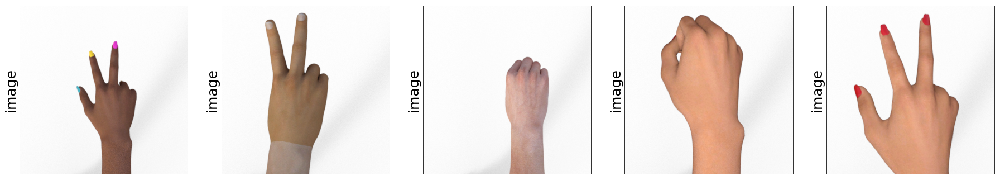

In [5]:
from plot_utils import plot_image_grid
num_show = 5

hands_val_dataset = hands_builder.as_dataset(split=tfds.Split.TEST).batch(num_show)
hands_val_dataset_iter = hands_val_dataset.skip(1).__iter__()
# ^ `.skip(1)` is called to skip the 1st batch, which is a bit "bland" in this dataset.
# We will use the 2nd batch for our illustrations, as it has more diverse hands...
batch = next(hands_val_dataset_iter)

fig = plot_image_grid([batch['image'].numpy()], titles=['image'], transpose=True)
fig.show()

### Input pipeline with `tf.data`

We have our images ready, but we still need to adapt the input pipelines to our use-case. As we did in previous chapters, we will use `tf.data` to serve training/validation batches to our model (see Chpater 7 for an in-depth presentation of this API). Copied from previous notebooks, the pipeline below does the following:

- It instantiate a `tf.data.Dataset` of our use-case images through `tensorflow-datasets`;
- It randomly augments the training images (random changes of brightness/saturation, random cropping/scaling, etc.);
- It duplicates the images and downscales one in each pair (**the downscaled images will be our model's inputs, the original ones the targets**);
- It batches the images together (if `batch_size > 1`) and repeat the process for `num_epochs`.

In [32]:
import functools

def _prepare_data_fn(features, scale_factor=4, augment=True,
                     return_batch_as_tuple=True, seed=None):
    """
    Resize image to expected dimensions, and opt. apply some random transformations.
    :param features:              Data
    :param scale_factor:          Scale factor for the task
    :param augment:               Flag to augment the images with random operations
    :param return_batch_as_tuple: Flag to return the batch data as tuple instead of dict
    :param seed:                  Seed for random operations
    :return:                      Processed data
    """
    
    # Tensorflow-Dataset returns batches as feature dictionaries, expected by Estimators.
    # To train Keras models, it is more straightforward to return the batch content as tuples.
    
    image = features['image']
    # Convert the images to float type, also scaling their values from [0, 255] to [0., 1.]:
    image = tf.image.convert_image_dtype(image, tf.float32)
    
    # Computing the scaled-down shape:
    original_shape = tf.shape(image)
    original_size = original_shape[-3:-1]
    scaled_size = original_size // scale_factor
    # Just in case the original dimensions were not a multiple of `scale_factor`,
    # we slightly resize the original image so its dimensions now are
    # (to make the loss/metrics computations easier during training):
    original_size_mult = scaled_size * scale_factor
    
    # Opt. augmenting the image:
    if augment:
        original_shape_mult = (original_size_mult, [tf.shape(image)[-1]])
        if len(image.shape) > 3: # batched data:
            original_shape_mult = ([tf.shape(image)[0]], *original_shape_mult)
        original_shape_mult = tf.concat(original_shape_mult, axis=0)
        
        # Randomly applied horizontal flip:
        image = tf.image.random_flip_left_right(image)

        # Random B/S changes:
        image = tf.image.random_brightness(image, max_delta=0.1, seed=seed)
        image = tf.image.random_saturation(image, lower=0.5, upper=1.5, seed=seed)
        image = tf.clip_by_value(image, 0.0, 1.0) # keeping pixel values in check

        # Random resize and random crop back to expected size:
        random_scale_factor = tf.random.uniform([1], minval=1.0, maxval=1.2, 
                                                dtype=tf.float32, seed=seed)
        scaled_height = tf.cast(tf.multiply(tf.cast(original_size[0], tf.float32), 
                                            random_scale_factor), 
                                tf.int32)
        scaled_width = tf.cast(tf.multiply(tf.cast(original_size[1], tf.float32), 
                                           random_scale_factor), 
                               tf.int32)
        scaled_shape = tf.squeeze(tf.stack([scaled_height, scaled_width]))
        image = tf.image.resize(image, scaled_shape)
        image = tf.image.random_crop(image, original_shape, seed=seed)
    
    # Generating the data pair for super-resolution task, 
    # i.e. the downscaled image + its original version
    image_downscaled = tf.image.resize(image, scaled_size)
    
    # Just in case the original dimensions were not a multiple of `scale_factor`,
    # we slightly resize the original image so its dimensions now are
    # (to make the loss/metrics computations easier during training):
    original_size_mult = scaled_size * scale_factor
    image = tf.image.resize(image, original_size_mult)
    
    features = (image_downscaled, image) if return_batch_as_tuple else {'image': image_downscaled,
                                                                        'label': image}
    return features


def get_hands_dataset_for_superres(phase='train', scale_factor=4, batch_size=32, num_epochs=None, 
                                   shuffle=True, augment=False, return_batch_as_tuple=True, seed=None):
    """
    Instantiate a CIFAR-100 dataset.
    :param phase:                 Phase ('train' or 'val')
    :param scale_factor:          Scale factor for the task
    :param batch_size:            Batch size
    :param num_epochs:            Number of epochs (to repeat the iteration - infinite if None)
    :param shuffle:               Flag to shuffle the dataset (if True)
    :param augment:               Flag to augment the images with random operations
    :param return_batch_as_tuple: Flag to return the batch data as tuple instead of dict
    :param seed:                  Seed for random operations
    """

    assert(phase == 'train' or phase == 'test')
    
    prepare_data_fn = functools.partial(
        _prepare_data_fn, scale_factor=scale_factor, augment=augment,
        return_batch_as_tuple=return_batch_as_tuple, seed=seed)

    superres_dataset = hands_builder.as_dataset(
        split=tfds.Split.TRAIN if phase =='train' else tfds.Split.TEST)
    superres_dataset = superres_dataset.repeat(num_epochs)
    if shuffle:
        superres_dataset = superres_dataset.shuffle(
            hands_builder.info.splits[phase].num_examples, seed=seed)
    superres_dataset = superres_dataset.batch(batch_size)
    superres_dataset = superres_dataset.map(prepare_data_fn, num_parallel_calls=4)
    superres_dataset = superres_dataset.prefetch(1)
    
    return superres_dataset

We now initialize our training and validation input pipelines accordingly:

In [33]:
# Number of images:
num_train_imgs = hands_builder.info.splits['train'].num_examples
num_val_imgs = hands_builder.info.splits['test'].num_examples

train_steps_per_epoch = math.ceil(num_train_imgs / batch_size)
val_steps_per_epoch   = math.ceil(num_val_imgs / batch_size)

# Input shape:
input_shape = hands_builder.info.features['image'].shape

# Datasets:
train_hands_dataset = get_hands_dataset_for_superres(
    phase='train', scale_factor=scale_factor, batch_size=batch_size, num_epochs=num_epochs, 
    augment=True, shuffle=True, seed=random_seed)

val_hands_dataset = get_hands_dataset_for_superres(
    phase='test', scale_factor=scale_factor, batch_size=batch_size, num_epochs=1, 
    augment=False, shuffle=False, seed=random_seed)

Let us make sure our pipelines are working as expected, by visualizing a batch. For a one-on-one comparison and to better measure the effect of the downsampling, we use TensorFlow to re-scale the images back to their original dimensions.

PSNR for each pair: [30.457941 30.29634  36.18808  31.426107 30.102022]


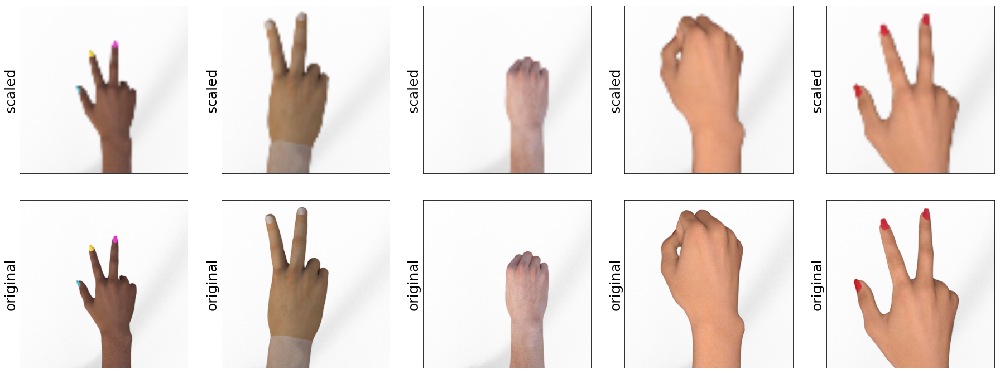

In [34]:
from plot_utils import plot_image_grid

val_hands_dataset_show = val_hands_dataset.take(1)
val_images_input, val_images_target = next(val_hands_dataset_show.__iter__())
val_images_input = val_images_input[num_show:(num_show * 2)] # skipping 1st "num_show" batch
val_images_target = val_images_target[num_show:(num_show * 2)]

# Resizing the image back with default method to show the artifacts it causes:
val_images_input_resized = tf.image.resize(val_images_input, tf.shape(val_images_target)[1:3])
val_psnr_result = tf.image.psnr(val_images_target, val_images_input_resized, max_val=1.)

# Displaying some examples:
figure = plot_image_grid([val_images_input_resized.numpy(), val_images_target.numpy()],
                         titles=["scaled", "original"], transpose=True)
figure.show()

print("PSNR for each pair: {}".format(val_psnr_result.numpy()))

We can clearly see the upscaling artifacts / missing details in the tampered images, as confirmed by their low PSNR. For later comparison, let us compute the average PSNR for the whole validation dataset:

In [35]:
psnr_val = tf.convert_to_tensor([], dtype=tf.float32)
for v_images_input, v_images_target in val_hands_dataset:
    v_images_input = tf.image.resize(v_images_input, tf.shape(v_images_target)[1:3])
    val_psnr_result = tf.image.psnr(v_images_target, v_images_input, max_val=1.)
    
    psnr_val = tf.concat((psnr_val, val_psnr_result), axis=0)
    
num_images = psnr_val.shape[0]
psnr_val = tf.reduce_mean(psnr_val).numpy()
print("Avg PSNR using default `tf.image.resize_images()` to scale up the {} val images: {}".format(
    num_images, psnr_val))

Avg PSNR using default `tf.image.resize_images()` to scale up the 372 val images: 31.36393928527832


The task of our model will be therefore to recover some of the details in the _corrupted_ images (and achieve a better PSNR, i.e., above **~31.4dB**).

## Building and Training a Deep Auto-Encoder

In the following section, we will build our first convolutional auto-encoder, which will allow us to efficiently process images, whatever their dimensions.

## Convolutional Auto-Encoder

As usual, we will stick with the Keras API to implement our model, though our readers are welcome to try reimplementing everything, e.g., using `tf.layers`.

In [36]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Lambda, Conv2D, Conv2DTranspose

As already mentioned in the chapter and in this notebook, we will tackle image super-resolution with an auto-encoder, similar to how we dealt with image denoising. 

Therefore, the idea is to **first use some standard algorithm to scale our downsample input back to its original shape** (e.g., using _bilinear interpolation_), before feeding it to our model. Like in the previous notebook, the task of our model is then to recover the _corrupted_ image, i.e., to remove the artifacts caused by the standard upsacling and to recover some details lost with the downsampling (c.f. images above). This way our model can be trained with minimal supervision (c.f. chapter), simply computing a loss between its outputs and the original images.
Once trained, our model could be used along  this standard upscaling algorithm, to improve the result quality.

Concretely, we thus add to our model a first layer which upscales the downsampled input images back to their original shape (using bilinear interpolation implemented by `tf.image.resize_images()`):

In [37]:
Upscale = lambda name: Lambda(
    lambda images: tf.image.resize(images, tf.shape(images)[-3:-1] * scale_factor), 
    name=name)

Then we build the **encoder** and **decoder** parts of our model, **using standard and transposed convolutions**.

In [38]:
def simple_dae(inputs, kernel_size=3, filters_orig=16, layer_depth=4):
    """
    Build a simple fully-convolutional DAE network.
    :param inputs:        Input tensor/placeholder
    :param kernel_size:   Kernel size for the convolutions
    :param filters_orig:  Number of filters for the 1st CNN layer (then multiplied by 2 each layer)
    :param layer_depth:   Number of layers composing the encoder/decoder
    :return:              DAE network (Keras Functional API)
    """

    # Encoding layers:
    filters = filters_orig
    x = inputs
    for i in range(layer_depth):
        x = Conv2D(filters=filters, kernel_size=kernel_size,
                   activation='relu', strides=2, padding='same',
                   name='enc_conv{}'.format(i))(x)
        filters = min(filters * 2, 512)

    # Decoding layers:
    for i in range(layer_depth):
        filters = max(filters // 2, filters_orig)
        x = Conv2DTranspose(filters=filters, kernel_size=kernel_size,
                            activation='relu', strides=2, padding='same',
                            name='dec_deconv{}'.format(i))(x)
    decoded = Conv2D(filters=inputs.shape[-1], kernel_size=1,
                     activation='sigmoid', padding='same',
                     name='dec_output')(x)
    # note: we use a sigmoid for the last activation, as we want the output values
    # to be between 0 and 1, like the input ones.
    
    return decoded

To have a look how it would process a given image, let us instantiate our network for a fixed input size, and print its summary:

In [39]:
inputs_fixed = Input(shape=(91, 91, 3), name='input')

outputs = simple_dae(inputs_fixed, kernel_size=4, filters_orig=32, layer_depth=4)

autoencoder_example = Model(inputs_fixed, outputs)
autoencoder_example.summary(positions=[.35, .65, .75, 1.]) # `positions` adapts the printed cols' width.

del autoencoder_example

Model: "model_5"
_________________________________________________________________
Layer (type)          Output Shape        Param 
input (InputLayer)    [(None, 91, 91, 3)] 0     
_________________________________________________________________
enc_conv0 (Conv2D)    (None, 46, 46, 32)  1568  
_________________________________________________________________
enc_conv1 (Conv2D)    (None, 23, 23, 64)  32832 
_________________________________________________________________
enc_conv2 (Conv2D)    (None, 12, 12, 128) 131200
_________________________________________________________________
enc_conv3 (Conv2D)    (None, 6, 6, 256)   524544
_________________________________________________________________
dec_deconv0 (Conv2DTr (None, 12, 12, 256) 104883
_________________________________________________________________
dec_deconv1 (Conv2DTr (None, 24, 24, 128) 524416
_________________________________________________________________
dec_deconv2 (Conv2DTr (None, 48, 48, 64)  131136
______________

As we can see, our network indeed follows the encoder-decoder paradigm. The encoder extracts features, reducing the spatial dimensionality of the image layer after layer. Reciprocally, the decoder attempts to recover the original dimensions and content.


However, we can also observe that, when the dimensions of our images are not normalized/not even, it is possible that, after downsampling and upsampling through the encoder/decoder, we do **not obtain the exact original size** (with a difference of $\pm 1$px).
To avoid the problems this may cause (when computing the loss comparing outputs and targets), we define a layer to slightly resize the generated image to the target dimensions:

In [40]:
ResizeToSame = lambda name: Lambda(
    lambda images: tf.image.resize(images[0], tf.shape(images[1])[-3:-1]), 
    # `images` is a tuple of 2 tensors.
    # We resize the first image tensor to the shape of the 2nd
    name=name)

Combining everything together, we build our network for image super-resolution:

In [41]:
def simple_dae_for_super_resolution(inputs, kernel_size=3, filters_orig=16, layer_depth=4):
    """
    Build a simple fully-convolutional DAE network.
    :param inputs:        Input tensor/placeholder
    :param kernel_size:   Kernel size for the convolutions
    :param filters_orig:  Number of filters for the 1st CNN layer (then multiplied by 2 each layer)
    :param layer_depth:   Number of layers composing the encoder/decoder
    :return:              DAE network (Keras Functional API)
    """
    
    # To have a symmetrical auto-encoder, we up-sample the input images to 
    # their target dimensions, using the default interpolation up-scaling.
    # The task of the auto-encoder will be to remove the artifacts/noise caused by
    # this default operation.
    resized_inputs = Upscale(name='upscale_input')(inputs)
    
    decoded = simple_dae(resized_inputs, kernel_size, filters_orig, layer_depth)
    
    # We take care of the aforementioned edge-case:
    decoded = ResizeToSame(name='dec_output_scale')([decoded, resized_inputs])
    
    return decoded

We can now instantiate our model:

In [42]:
# Network hyper-parameters:
kernel_size  =  4
filters_orig = 32
layer_depth  =  4

In [43]:
# Image size will vary. Therefore, we use `None` for the variable dimensions:
inputs = Input(shape=(None, None, input_shape[-1]), name='input')

decoded = simple_dae_for_super_resolution(inputs, kernel_size, filters_orig, layer_depth)

# Auto-encoder model:
autoencoder = Model(inputs, decoded)
autoencoder.summary(positions=[.35, .65, .75, 1.]) # `positions` adapts the printed cols' width.

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                      Output Shape                 Param #   Connected to             
input (InputLayer)                [(None, None, None, 3)]      0                                  
__________________________________________________________________________________________________
upscale_input (Lambda)            (None, None, None, 3)        0         input[0][0]              
__________________________________________________________________________________________________
enc_conv0 (Conv2D)                (None, None, None, 32)       1568      upscale_input[0][0]      
__________________________________________________________________________________________________
enc_conv1 (Conv2D)                (None, None, None, 64)       32832     enc_conv0[0][0]          
____________________________________________________________________________________________

Since our model is **fully-convolutional** and not so deep, its number of trainable parameters is rather low, which will simplify the training.

### Training

Reusing the **custom metrics and callbacks** defined in the previous notebooks, we train our model: 

In [44]:
import functools
import collections
from keras_custom_callbacks import TensorBoardImageGridCallback, SimpleLogCallback

optimizer = tf.keras.optimizers.Adam()

psnr_metric = functools.partial(tf.image.psnr, max_val=1.)
psnr_metric.__name__ = 'psnr'

model_dir = os.path.join('.', 'models', 'superres_dae')

metrics_to_print = collections.OrderedDict([("loss", "loss"), ("v-loss", "val_loss"),
                                            ("psnr", "psnr"), ("v-psnr", "val_psnr")])
callbacks  = [
    # Callback to interrupt the training if the validation loss/metrics stops improving for some epochs:
    tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss',
                                     restore_best_weights=True),
    # Callback to log the graph, losses and metrics into TensorBoard:
    tf.keras.callbacks.TensorBoard(log_dir=model_dir, histogram_freq=0, write_graph=True),
    # Callback to simply log metrics at the end of each epoch (saving space compared to verbose=1/2):
    SimpleLogCallback(metrics_to_print, num_epochs=num_epochs, log_frequency=1),
    # Callback to log some validation results as image grids into TensorBoard:
    TensorBoardImageGridCallback(
        log_dir=model_dir, input_images=val_images_input.numpy(), target_images=val_images_target.numpy(), 
        tag='ae_super_res_results', figsize=(num_show * 3, 3 * 3), 
        grayscale=True, transpose=True)
]

# def mae(y_true, y_pred):
#     loss = tf.math.abs(y_true - y_pred)
#     return tf.reduce_mean(loss)
optimizer = tf.optimizers.Adam(learning_rate=1e-4)
autoencoder.compile(optimizer=optimizer, loss='mae', metrics=[psnr_metric])

history_ae = autoencoder.fit(
    train_hands_dataset,  epochs=num_epochs, steps_per_epoch=train_steps_per_epoch,
    validation_data=val_hands_dataset, validation_steps=val_steps_per_epoch,
    verbose=0, callbacks=callbacks)

Training: start.
Epoch  0/300: loss = 0.263; v-loss = 0.114; psnr = 10.334; v-psnr = 15.792
Epoch  1/300: loss = 0.112; v-loss = 0.059; psnr = 15.958; v-psnr = 19.799
Epoch  2/300: loss = 0.094; v-loss = 0.053; psnr = 17.067; v-psnr = 20.407
Epoch  3/300: loss = 0.080; v-loss = 0.064; psnr = 18.567; v-psnr = 18.947
Epoch  4/300: loss = 0.062; v-loss = 0.052; psnr = 20.319; v-psnr = 21.189
Epoch  5/300: loss = 0.056; v-loss = 0.046; psnr = 20.992; v-psnr = 21.809
Epoch  6/300: loss = 0.058; v-loss = 0.046; psnr = 21.078; v-psnr = 21.619
Epoch  7/300: loss = 0.051; v-loss = 0.045; psnr = 21.756; v-psnr = 22.089
Epoch  8/300: loss = 0.046; v-loss = 0.041; psnr = 22.760; v-psnr = 22.809
Epoch  9/300: loss = 0.046; v-loss = 0.038; psnr = 22.809; v-psnr = 23.370
Epoch 10/300: loss = 0.042; v-loss = 0.052; psnr = 23.212; v-psnr = 21.785
Epoch 11/300: loss = 0.047; v-loss = 0.034; psnr = 22.843; v-psnr = 24.723
Epoch 12/300: loss = 0.046; v-loss = 0.042; psnr = 23.123; v-psnr = 22.483
Epoch 13

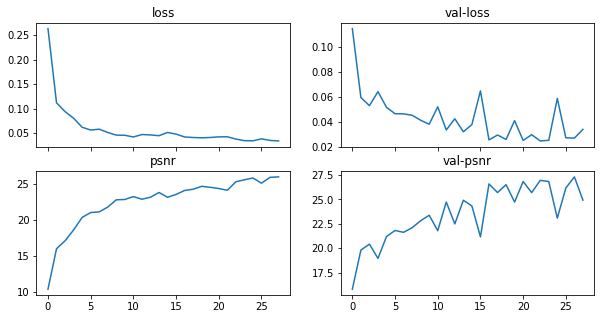

In [45]:
fig, ax = plt.subplots(2, 2, figsize=(10, 5), sharex='col')
ax[0, 0].set_title("loss")
ax[0, 1].set_title("val-loss")
ax[1, 0].set_title("psnr")
ax[1, 1].set_title("val-psnr")

ax[0, 0].plot(history_ae.history['loss'])
ax[0, 1].plot(history_ae.history['val_loss'])
ax[1, 0].plot(history_ae.history['psnr'])
ax[1, 1].plot(history_ae.history['val_psnr'])

As expected, our model converged rather fast, but its performance is quite disappointing. With a PSNR of **~27.3dB** at best on the validation images, we are far below the PSNR of **~31.4dB** when purely using bilinear interpolation to upscale them. Even the metric on the training images stayed below. In terms of PSNR, our model makes things worse... 

**Note:** PSNR is not an absolute measure of image quality, only evaluating how bad the noise is. Images with the same PSNR may have different _**perceptual quality**_ to human eyes (e.g., an image may have some heavy noise, but only in regions which do not contain _salient_ details and therefore not really affecting the perceived quality). Evaluating the perceptual quality of images is still an open problem, 

Thanks to our custom callback, we could already observe some results in Tensorboard (console command `tensorboard --logdir ./models` then [http://localhost:6006/#images](http://localhost:6006/#images)). Still, let us draw some results here:

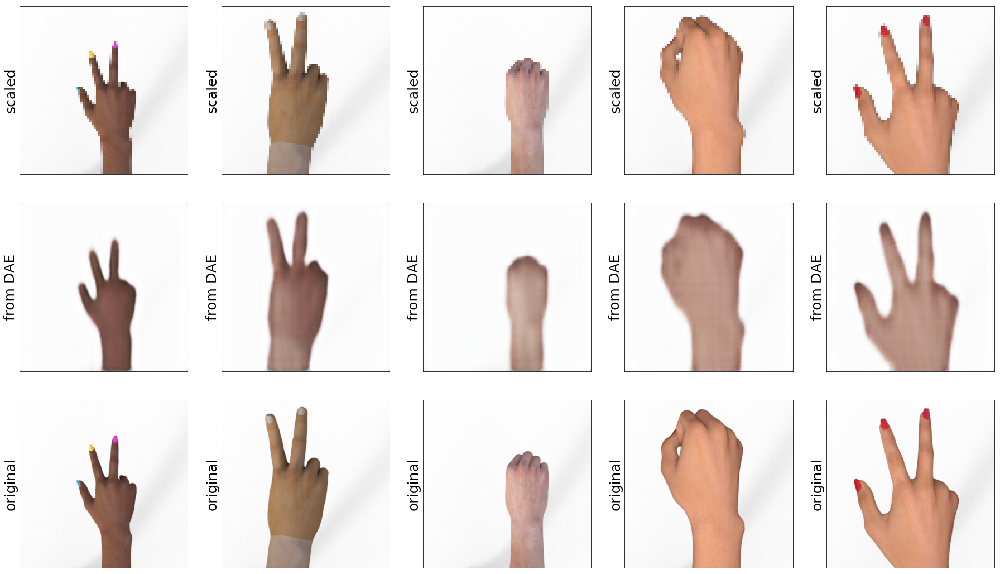

In [46]:
val_images_pred = autoencoder.predict(val_images_input)

figure = plot_image_grid(
    [val_images_input.numpy(), val_images_pred, val_images_target.numpy()], 
    titles=["scaled", "from DAE", "original"], transpose=True)
figure.show()

As we can see, the network did its best to soften the sampling artifacts, but images are instead left blurry. We can also notice that colors are sometimes altered. All in all, our images do not look better indeed...

## Building and Training a U-Net

We will try to do better. In Chapter 6, we presented some more advanced encoder-decoder architecture. It is time to re-implement and apply one of them. In the following section, we will therefore build our own **_U-Net_**[$^2$](#ref) and apply it to image super-resolution.

### U-Net architecture

Most of the problems with our previous model can be attributed to the **network's bottleneck**. Because of its architecture, our model has to find ways to compress the information, and the decoder only receives this lower-dimensional input to condition its reconstruction. If an image contains unusual features (e.g., unusual objects or colors), the encoder will not properly compress them, and the decoder won't have any other inputs to recover these approximations.

_U-Net_[$^2$](#ref) has a straightforward solution to this problem: it adds a **skip/shortcut** connection between pairs of encoding/decoding blocks. Therefore, each decoding block is not only conditioned by the rich-yet-low-dimensional features coming from the previous block, but also by the less-coarse map from the parallel encoding block. In other words, the decoding blocks are **provided with both the contextual information** from the preceding block, **and with the location information** from the encoding path.

As a quick reminder from the chapter, this is the U-Net architecture:

![U-Net Architecture](./notebook_images/unet.png)

**Note:** **batch normalization** and **dropout** layers are not represented here. Typically, each convolutional layer (`conv` in  the figure) actually does the following here: _convolution_, (opt.) _batch normalization_, _activation_. Furthermore, the **_Leaky ReLU_** function is commonly used as activation, instead of the standard _ReLU_. Introduced by Kaiming He et al.[$^3$](#ref), this _LReLU_ allows a small negative slopes for negative values, solving potential gradient problems (see paper for details[$^3$](#ref))

To reimplement this architecture, let us go bottom-up. We will start by writing a function wrapping the operations actually done by `conv`, then another wrapping each block of two `conv` together:

In [47]:
from tensorflow.keras.layers import (
    Dropout, MaxPooling2D, LeakyReLU, concatenate, BatchNormalization)


def name_layer_factory(num=0, name_prefix="", name_suffix=""):
    """
    Helper function to name all our layers.
    """
    def name_layer_fn(layer):
        return '{}{}{}-{}'.format(name_prefix, layer, name_suffix, num)
    
    return name_layer_fn


def conv_bn_lrelu(filters, kernel_size=3, batch_norm=True,
                  kernel_initializer='he_normal', padding='same',
                  name_fn=lambda layer: "conv_bn_lrelu-{}".format(layer)):
    """
    Return a function behaving like a sequence convolution + BN + lReLU.
    :param filters:              Number of filters for the convolution
    :param kernel_size:          Kernel size for the convolutions
    :param batch_norm:           Flag to perform batch normalization
    :param kernel_initializer:   Name of kernel initialization method
    :param padding:              Name of padding option
    :param name_fn:              Function to name each layer of this sequence
    :return:                     Function chaining layers
    """
    
    def block(x):
        x = Conv2D(filters, kernel_size=kernel_size, 
                   activation=None, kernel_initializer=kernel_initializer, 
                   padding=padding, name=name_fn('conv'))(x)
        if batch_norm:
            x = BatchNormalization(name=name_fn('bn'))(x)
        x = LeakyReLU(alpha=0.3, name=name_fn('act'))(x)
        return x
    
    return block


def unet_conv_block(filters, kernel_size=3,
                    batch_norm=True, dropout=False, 
                    name_prefix="enc_", name_suffix=0):
    """
    Return a function behaving like a U-Net convolution block.
    :param filters:              Number of filters for the convolution
    :param kernel_size:          Kernel size for the convolutions
    :param batch_norm:           Flag to perform batch normalization
    :param dropout:              NFlag to perform dropout between the two convs
    :param name_prefix:          Prefix for the layer names
    :param name_suffix:          FSuffix for the layer names
    :return:                     Function chaining layers
    """
    
    def block(x):
        # First convolution:
        name_fn = name_layer_factory(1, name_prefix, name_suffix)
        x = conv_bn_lrelu(filters, kernel_size=kernel_size, batch_norm=batch_norm, 
                          name_fn=name_layer_factory(1, name_prefix, name_suffix))(x)
        if dropout:
            x = Dropout(0.2, name=name_fn('drop'))(x)

        # Second convolution:
        name_fn = name_layer_factory(2, name_prefix, name_suffix)
        x = conv_bn_lrelu(filters, kernel_size=kernel_size, batch_norm=batch_norm, 
                          name_fn=name_layer_factory(2, name_prefix, name_suffix))(x)

        return x
    
    return block

Now we can chain everything together, according to the architecture presented above. Since we had already reimplemented **_ResNET_** in Chapter 3, there should be nothing really surprising below:

In [48]:
# As the dimensions of our images are not normalized, and often not even, it is
# possible that after downsampling and upsampling, we do not reobtain the original size
# (with a difference of +/- 1px).
# To avoid the problems this may cause, we define a layer to slightly resize the generated
# image to the dimensions of the target one:
ResizeToSame = lambda name: Lambda(
    lambda images: tf.image.resize(images[0], tf.shape(images[1])[-3:-1]), 
    # `images` is a tuple of 2 tensors.
    # We resize the first image tensor to the shape of the 2nd
    name=name)


def unet(x, layer_depth=4, filters_orig=32, kernel_size=4, 
         batch_norm=True, dropout=True, final_activation='sigmoid'):
    """
    Define a U-Net network.
    :param x:                    Input tensor/placeholder
    :param filters_orig:         Number of filters for the 1st CNN layer
    :param kernel_size:          Kernel size for the convolutions
    :param batch_norm:           Flag to perform batch normalization
    :param dropout:              Flag to perform dropout
    :param final_activation:     Name of activation function for the final layer
    :return:                     Network (Keras Functional API)
    """
    num_channels = x.shape[-1]
    
    # Encoding layers:
    filters = filters_orig
    outputs_for_skip = []
    for i in range(layer_depth):
        
        # Convolution block:
        x_conv = unet_conv_block(filters, kernel_size, 
                                 dropout=dropout, batch_norm=batch_norm, 
                                 name_prefix="enc_", name_suffix=i)(x)
        
        # We save the pointer to the output of this encoding block,
        # to pass it to its parallel decoding block afterwards:
        outputs_for_skip.append(x_conv)

        # Downsampling:
        x = MaxPooling2D(2)(x_conv)

        filters = min(filters * 2, 512)

    # Bottleneck layers:
    x = unet_conv_block(filters, kernel_size, dropout=dropout, 
                        batch_norm=batch_norm, name_suffix='_btleneck')(x)

    # Decoding layers:
    for i in range(layer_depth):
        filters = max(filters // 2, filters_orig)

        # Upsampling:
        name_fn = name_layer_factory(3, "ups_", i)
        x = Conv2DTranspose(filters, kernel_size=kernel_size, strides=2, 
                            activation=None, kernel_initializer='he_normal', 
                            padding='same', name=name_fn('convT'))(x)
        if batch_norm:
            x = BatchNormalization(name=name_fn('bn'))(x)
        x = LeakyReLU(alpha=0.3, name=name_fn('act'))(x)
    
        # Concatenation with the output of the corresponding encoding block:
        shortcut = outputs_for_skip[-(i + 1)]
        x = ResizeToSame(name='resize_to_same{}'.format(i))([x, shortcut])
        
        x = concatenate([x, shortcut], axis=-1, name='dec_conc{}'.format(i))

        # Convolution block:
        use_dropout = dropout and (i < (layer_depth - 2))
        x = unet_conv_block(filters, kernel_size, 
                            batch_norm=batch_norm, dropout=use_dropout,
                            name_prefix="dec_", name_suffix=i)(x)

    # x = Conv2D(filters=filters, kernel_size=kernel_size, activation='relu', 
    #            padding='same', name='dec_out1')(x)  
    # x = Conv2D(filters=filters, kernel_size=kernel_size, activation='relu', 
    #            padding='same', name='dec_out2')(x)    
    x = Conv2D(filters=num_channels, kernel_size=1, activation=final_activation, 
               padding='same', name='dec_output')(x)
    
    return x

This is it, we reimplemented _U-Net_! As we did with our basic DAE, we instantiate a dummy version with its input size fixed, just for the sake of visualizing how the tensor dimensions evolve through the network:

In [49]:
# Network hyper-parameters:
kernel_size  =  4
filters_orig = 32
layer_depth  =  4
use_batch_norm = batch_size > 1

In [50]:
inputs_fixed = Input(shape=(91, 91, 3), name='input')

outputs = unet(inputs_fixed, layer_depth, filters_orig, kernel_size, 
               use_batch_norm, dropout=False) # no dropout to shorten summary here

unet_example = Model(inputs_fixed, outputs)
unet_example.summary(positions=[.35, .65, .75, 1.]) # `positions` adapts the printed cols' width.

del unet_example

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                      Output Shape                 Param #   Connected to             
input (InputLayer)                [(None, 91, 91, 3)]          0                                  
__________________________________________________________________________________________________
enc_conv0-1 (Conv2D)              (None, 91, 91, 32)           1568      input[0][0]              
__________________________________________________________________________________________________
enc_bn0-1 (BatchNormalizationV2)  (None, 91, 91, 32)           128       enc_conv0-1[0][0]        
__________________________________________________________________________________________________
enc_act0-1 (LeakyReLU)            (None, 91, 91, 32)           0         enc_bn0-1[0][0]          
____________________________________________________________________________________________

Going a bit deeper and duplicating the convolution layers in each encoding/decoding block, our _U-Net_ is heavier than our previous model. Its number of parameters is still decent though. We can also see that while it also has a bottleneck (c.f. its typical U-shaped encoder-decoder architecture), the skip connections allow to circumvent it and pass signals between the encoding and decoding blocks.

### Training

We finally instantiate and train our new model, using the same script as before:

In [51]:
inputs = Input(shape=(None, None, input_shape[-1]), name='input')
resized_inputs = Upscale(name='upscale_input')(inputs)

outputs = unet(resized_inputs, layer_depth, filters_orig, kernel_size, use_batch_norm)

unet_model = Model(inputs, outputs)

In [52]:
# Opt. we reduce the batch size in case the device doesn't have enough memory:
batch_size = 16

# Datasets:
train_hands_dataset = get_hands_dataset_for_superres(
    phase='train', scale_factor=scale_factor, batch_size=batch_size, num_epochs=num_epochs, 
    augment=True, shuffle=True, seed=random_seed)

val_hands_dataset = get_hands_dataset_for_superres(
    phase='test', scale_factor=scale_factor, batch_size=batch_size, num_epochs=1, 
    augment=False, shuffle=False, seed=random_seed)

# Callbacks:
model_dir = os.path.join('.', 'models', 'superres_unet')


callbacks  = [
    # Callback to interrupt the training if the validation loss/metrics stops improving for some epochs:
    tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss',
                                     restore_best_weights=True),
    # Callback to log the graph, losses and metrics into TensorBoard:
    tf.keras.callbacks.TensorBoard(log_dir=model_dir, histogram_freq=0, write_graph=True),
    # Callback to simply log metrics at the end of each epoch (saving space compared to verbose=1/2):
    SimpleLogCallback(metrics_to_print, num_epochs=num_epochs, log_frequency=1),
    # Callback to log some validation results as image grids into TensorBoard:
    TensorBoardImageGridCallback(
        log_dir=model_dir, input_images=val_images_input.numpy(), target_images=val_images_target.numpy(), 
        tag='unet_super_res_results', figsize=(num_show * 3, 3 * 3), 
        grayscale=True, transpose=True)
]

# Compilation:
optimizer = tf.optimizers.Adam(learning_rate=1e-4)
unet_model.compile(optimizer=optimizer, loss='mae', metrics=[psnr_metric])

# Training:
history_unet = unet_model.fit(
    train_hands_dataset,  epochs=num_epochs, steps_per_epoch=train_steps_per_epoch,
    validation_data=val_hands_dataset, validation_steps=val_steps_per_epoch,
    verbose=0, callbacks=callbacks)

Training: start.
Epoch  0/300: loss = 0.237; v-loss = 0.654; psnr = 11.459; v-psnr = 2.419
Epoch  1/300: loss = 0.182; v-loss = 0.138; psnr = 13.765; v-psnr = 15.985
Epoch  2/300: loss = 0.167; v-loss = 0.119; psnr = 14.467; v-psnr = 17.277
Epoch  3/300: loss = 0.144; v-loss = 0.115; psnr = 15.631; v-psnr = 17.451
Epoch  4/300: loss = 0.134; v-loss = 0.116; psnr = 16.185; v-psnr = 17.550
Epoch  5/300: loss = 0.122; v-loss = 0.109; psnr = 17.000; v-psnr = 18.102
Epoch  6/300: loss = 0.110; v-loss = 0.100; psnr = 17.836; v-psnr = 18.875
Epoch  7/300: loss = 0.103; v-loss = 0.090; psnr = 18.349; v-psnr = 19.779
Epoch  8/300: loss = 0.092; v-loss = 0.081; psnr = 19.263; v-psnr = 20.722
Epoch  9/300: loss = 0.085; v-loss = 0.079; psnr = 19.970; v-psnr = 20.985
Epoch 10/300: loss = 0.082; v-loss = 0.064; psnr = 20.255; v-psnr = 22.431
Epoch 11/300: loss = 0.072; v-loss = 0.056; psnr = 21.494; v-psnr = 23.305
Epoch 12/300: loss = 0.063; v-loss = 0.051; psnr = 22.593; v-psnr = 23.961
Epoch 13/

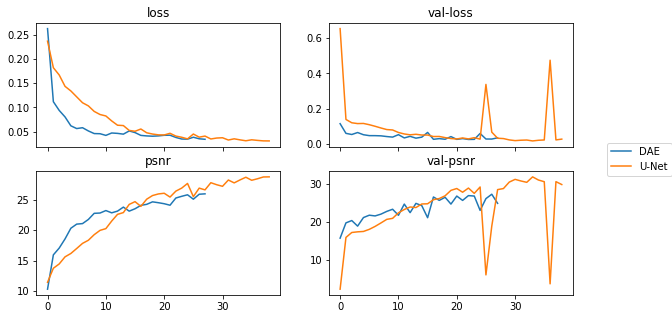

In [53]:
histories = {'DAE': history_ae, 'U-Net': history_unet}

fig, ax = plt.subplots(2, 2, figsize=(10, 5), sharex='col')
ax[0, 0].set_title("loss")
ax[0, 1].set_title("val-loss")
ax[1, 0].set_title("psnr")
ax[1, 1].set_title("val-psnr")

lines, labels = [], []
for config_name in histories:
    history = histories[config_name]
    ax[0, 0].plot(history.history['loss'])
    ax[0, 1].plot(history.history['val_loss'])
    ax[1, 0].plot(history.history['psnr'])
    line = ax[1, 1].plot(history.history['val_psnr'])
    lines.append(line[0])
    labels.append(config_name)

fig.legend(lines, labels, loc='center right', borderaxespad=0.1)
plt.subplots_adjust(right=0.87)

Though our training may have had some hiccups, the metrics look quite better, and it seems our network was able to reduce the sampling noise (c.f. best PSNR values = 31.8db > 31.4dB). Let us visualize here some results:

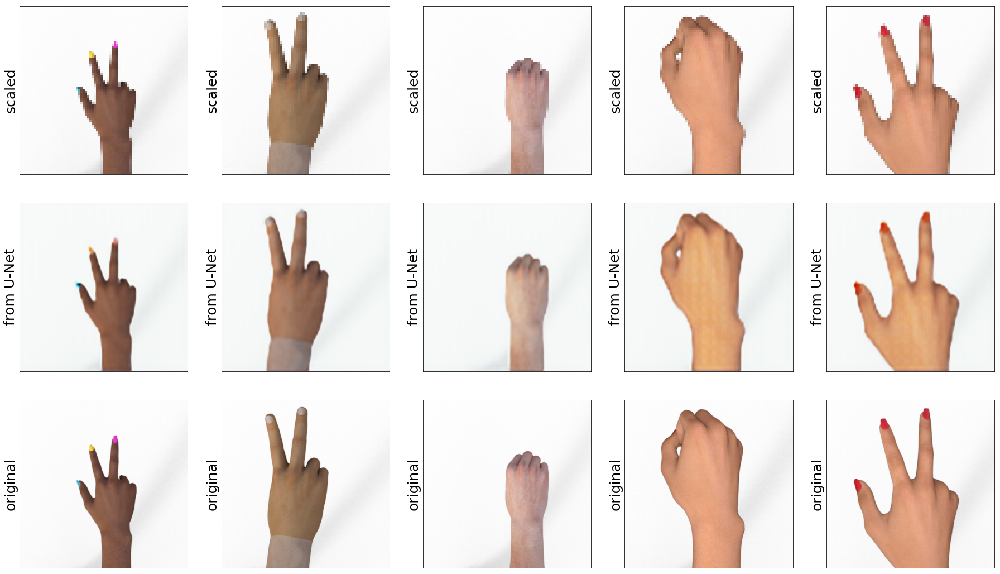

In [54]:
val_images_pred = unet_model.predict(val_images_input)

figure = plot_image_grid(
    [val_images_input.numpy(), val_images_pred, val_images_target.numpy()], 
    titles=["scaled", "from U-Net", "original"], transpose=True)
figure.show()

The gain in image quality may seem small, but image super-resolution is a complicated task for CNNs (c.f. book).

## Conclusion

Using image super-resolution as a pretext, we got acquainted with convolutional auto-encoders, and implemented our own U-Net. In the following notebooks, we will apply this architecture (and the FCN one) to another complex task: semantic segmentation.

<a id="ref"></a>
#### References

1. Moroney, L., 2019. Rock, Paper, Scissors Dataset. http://laurencemoroney.com/rock-paper-scissors-dataset (Accessed: 03.04.2019).
2. Ronneberger, O., Fischer, P., Brox, T., 2015. U-Net: Convolutional Networks for Biomedical Image Segmentation. arXiv:1505.04597 [cs].
3. He, K., Zhang, X., Ren, S., Sun, J., 2015. Delving deep into rectifiers: Surpassing human-level performance on imagenet classification. In: Proceedings of the IEEE International Conference on Computer Vision. pp. 10261034.